The task is to build a convolutional neural network for regression.  Your network will perform the simple task of looking at images of circles and estimating the radius of the circle.  You may find it easier to start with a CNN that classifies the MNIST data (google “mnist keras tutorial” and/or use the hello world model I shared on MARCC) and edit the code to perform the tasks below.

In [1]:
import numpy as np
import random
import matplotlib.pylab as plt
from tensorflow.keras.optimizers import Adam
import matplotlib as mpl

label_size = 14

mpl.rcParams['legend.fontsize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size 

mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

mpl.rcParams['axes.labelpad'] = 10

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)
from sklearn.model_selection import train_test_split


Images:  build 1000 images with np.zeros, each image 128x128 pixels in size.   Select a random number (between 10 and 50), and this random number will be a radius.  For every pixel within r of the center, change the value from 0 to 1.  You’ve just made a bunch of images with circles, and the circles vary in radius.

In [2]:
class Circle:
    def __init__(self):    
        self.size = 128
        self.r = random.randint(10,50)
        self.mid_pixel = 64
        blank = np.zeros(shape=(self.size,self.size))
        idx = np.arange(self.size)

        mid_pix = self.size/2
        x, y = mid_pix, mid_pix
        
        self.x = mid_pix
        self.y = mid_pix
        x_idx, y_idx = np.meshgrid(np.arange(blank.shape[0]), np.arange(blank.shape[1]))

        
        dist = np.sqrt((x_idx-x)**2+(y_idx-y)**2)
        self.dist = dist
        blank[np.where(dist<self.r)] = 1
        self.image = blank

    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(self.image,interpolation='none',cmap='binary')
        
        ticks = np.arange(0,129,32)
        plt.xticks(ticks),plt.yticks(ticks)
        plt.title(r'$r={}$'.format(self.r))
        plt.show()
        plt.close()
        
    def shift(self):
        """
        shift cluster randomly within bounds of image
        """
        r = self.r
        mid = self.mid_pixel #center pixel index of 384x384 image
        delta = self.size - self.mid_pixel - r
        x = np.random.randint(low=-1*delta,high=delta,size=1)[0]
        y = np.random.randint(low=-1*delta,high=delta,size=1)[0]

        self.x += mid
        self.y += mid
        image_shift = np.roll(self.image,shift=x,axis=0)
        self.image = np.roll(image_shift,shift=y,axis=1)
        
        return

In [3]:
# load circle objects into an array
cir_set = []
for i in range(1000):
    cir = Circle()
    cir.shift()
    cir_set.append(cir)
    

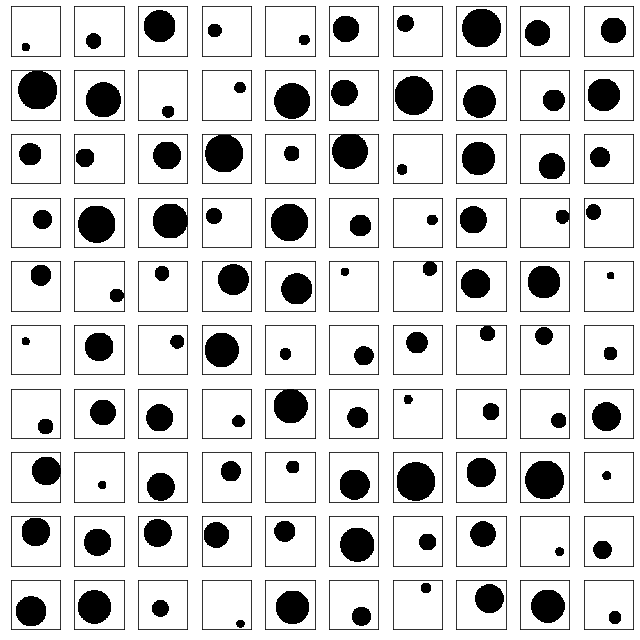

In [4]:
# plot a sample of 100 circles from our dataset
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(9,9))
for i, ax in enumerate(axes.flat):
    cir = cir_set[i]
    ax.imshow(cir.image,interpolation='none',cmap='binary')
    ax.set_yticks([])
    ax.set_xticks([])
space= 0.1
plt.subplots_adjust(wspace=space,hspace=space)
plt.tight_layout()
plt.savefig('10x10_rand_circ.png',dpi=300)
plt.show()

plt.close()

Compile the model with the Adam optimizer.

Train the model to take the images and output the radius labels.  Train for 250 epochs.

Assess the model:  make a scatter plot of true radius vs. predicted radius.

In [5]:
input_shape = (128,128,1) # width, height, channel number
pool_size = (2,2)
kernel_size = (3,3)
activation = 'relu'
strides = 2

In [6]:
model = keras.Sequential(
    [
        keras.Input(shape=(128,128,1)),
        
        # 1. 3×3 convolution with 16 filters
        layers.Conv2D(filters=16, kernel_size=(6,6), activation=activation),

        # 2. 2×2, stride-2 max pooling
        layers.MaxPooling2D(pool_size=pool_size, strides=strides),

        # 3. 3×3 convolution with 32 filters
        layers.Conv2D(filters=32, kernel_size=kernel_size, activation=activation),

        # 4. 2×2, stride-2 max pooling
        layers.MaxPooling2D(pool_size=pool_size, strides=strides),

        # 5. 3×3 convolution with 64 filters
        layers.Conv2D(filters=64, kernel_size=kernel_size, activation=activation),

        # 6. 2×2, stride-2 max pooling
        layers.MaxPooling2D(pool_size=pool_size, strides=strides),

        # 7. global average pooling
        layers.GlobalAveragePooling2D(),

        # 8. 10% dropout
        layers.Dropout(0.1),

        # 9. 200 neurons, fully connected
        layers.Dense(units=200),

        # 10. 10% dropout
        layers.Dropout(0.1),

        # 11. 100 neurons, fully connected
        layers.Dense(units=100),

        # 12. 20 neurons, fully connected
        layers.Dense(units=20),

        # 13. output neuron
        layers.Dense(units=1)

    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 16)      592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

(14,14,64)
probing length scales that are 128/14
9 pixel lengths

In [7]:
# fit the keras model on the dataset
data = np.array([cir.image for cir in cir_set])
labels = np.array([cir.r for cir in cir_set])

idx = np.arange(0,1000,1)
test_idx = random.sample(list(idx),k=100)
train_idx = np.delete(idx, test_idx)

x_train, y_train = data[train_idx], labels[train_idx]
x_train = x_train.reshape(-1, 128, 128, 1)
x_test, y_test = data[test_idx], labels[test_idx]
print(x_train.shape)

(900, 128, 128, 1)


In [8]:
#labels = tf.expand_dims(labels, axis=-1)
opt = Adam(lr=0.0005)
model.compile(optimizer=opt,loss="mse", metrics=["accuracy"])
model.fit(x=x_train,y=y_train, epochs=250, batch_size=128, validation_split=0.1)

Epoch 1/250
7/7 [==============================] - 5s 682ms/step - loss: 989.1756 - accuracy: 0.0000e+00 - val_loss: 924.4681 - val_accuracy: 0.0000e+00
Epoch 2/250
7/7 [==============================] - 4s 596ms/step - loss: 919.7659 - accuracy: 0.0000e+00 - val_loss: 720.2532 - val_accuracy: 0.0000e+00
Epoch 3/250
7/7 [==============================] - 5s 643ms/step - loss: 636.4149 - accuracy: 0.0000e+00 - val_loss: 113.6899 - val_accuracy: 0.0000e+00
Epoch 4/250
7/7 [==============================] - 4s 600ms/step - loss: 92.4062 - accuracy: 0.0000e+00 - val_loss: 87.1625 - val_accuracy: 0.0000e+00
Epoch 5/250
7/7 [==============================] - 5s 642ms/step - loss: 59.4569 - accuracy: 0.0000e+00 - val_loss: 56.8208 - val_accuracy: 0.0000e+00
Epoch 6/250
7/7 [==============================] - 4s 624ms/step - loss: 63.5237 - accuracy: 0.0000e+00 - val_loss: 13.9643 - val_accuracy: 0.0000e+00
Epoch 7/250
7/7 [==============================] - 4s 617ms/step - loss: 22.5448 - accur

In [9]:
print("Evaluate on test data")
x_test = x_test.reshape(-1, 128, 128, 1)
results = model.evaluate(x_test, y_test, batch_size=128)

Evaluate on test data
1/1 [==============================] - 0s 148ms/step - loss: 3.4035 - accuracy: 0.0000e+00


In [10]:
train_pred = model.predict(x_train,verbose=1)
test_pred = model.predict(x_test,verbose=1)


4/4 [==============================] - 0s 37ms/step


In [1]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(y_train,train_pred,s=5,marker=".",label='Training data')
ax.scatter(y_test,test_pred,s=5,marker=".",label='Test data')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=200)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('Original Radius')
ax.set_ylabel('CNN Radius')
ticks = np.arange(10,51,5)
ax.set_xticks(ticks),ax.set_yticks(ticks)
plt.title('Shifted',fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('1to1_plot_radius_approx-shift.png',dpi=250,bbox_inches='tight')
plt.show()
plt.close()

NameError: name 'plt' is not defined